# Libraries

In [36]:
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import seaborn as sns

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Image Size and Directory Path

In [37]:
img_width, img_height = 224, 224
num_classes = 10
batch_size = 32
dataset_dir = "/content/drive/My Drive/Dataset_balance"

# Model Building

In [38]:
base_model = DenseNet121(weights = 'imagenet', include_top =False, input_shape=(img_width, img_height, 3))

29084464/29084464 [==============================] - 0s 0us/step


In [39]:
for layer in base_model.layers:
  layer.trainable = False

In [40]:
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation = 'softmax')(x)

In [41]:
model = Model(
    inputs=base_model.input, 
    outputs=predictions
    )

In [42]:
model.compile(
    optimizer='adam', 
    loss = 'categorical_crossentropy', 
    metrics = ['accuracy']
    )

In [43]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_3[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                            

# Pre-Process Data using ImageDataGenerator

In [44]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
  )

In [45]:
train_data = train_datagen.flow_from_directory(
    os.path.join(dataset_dir, "train"),
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = 'categorical'
)

Found 10040 images belonging to 10 classes.


In [46]:
train_data.class_indices

{'Bacterial_spot': 0,
 'Early_blight': 1,
 'Late_blight': 2,
 'Leaf_Mold': 3,
 'Septoria_leaf_spot': 4,
 'Spider_mites Two-spotted_spider_mite': 5,
 'Target_Spot': 6,
 'Tomato_Yellow_Leaf_Curl_Virus': 7,
 'Tomato_mosaic_virus': 8,
 'healthy': 9}

In [47]:
train_data.image_shape

(224, 224, 3)

In [48]:
val_datagen = ImageDataGenerator(rescale = 1./255)

In [49]:
val_data = val_datagen.flow_from_directory(
    os.path.join(dataset_dir, "val"),
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = 'categorical'
)

Found 1250 images belonging to 10 classes.


# Visualizing Data

<Axes: xlabel='labels', ylabel='count'>

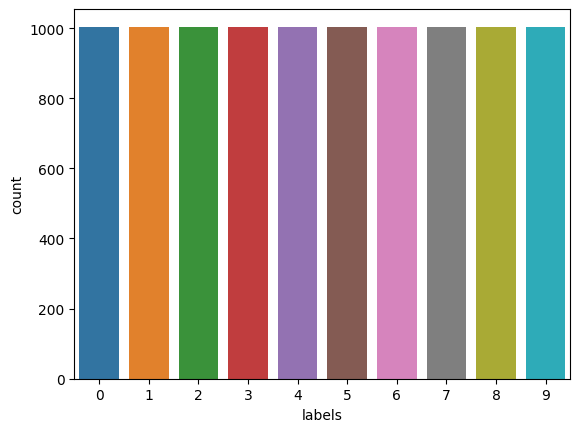

In [50]:
labelDf = pd.DataFrame(train_data.labels)
labelDf.rename(columns = {0:'labels'}, inplace = True)

sns.countplot(data=labelDf, x='labels')

# Model Checkpoint

In [51]:
from tensorflow.keras.callbacks import ModelCheckpoint

mc = ModelCheckpoint(filepath= "/content/drive/My Drive/denseNet121.h5", 
                     monitor  = "val_accuracy", 
                     verbose = 1, 
                     save_best_only= True)

In [52]:
his = model.fit(
    train_data,
    steps_per_epoch = batch_size,
    epochs = 40,
    validation_data = val_data,
    validation_steps = batch_size,
    callbacks = [mc]
)

Epoch 1/40
32/32 [==============================] - ETA: 0s - loss: 32.2677 - accuracy: 0.3307
Epoch 1: val_accuracy improved from -inf to 0.59766, saving model to /content/drive/My Drive/denseNet121.h5
32/32 [==============================] - 29s 665ms/step - loss: 32.2677 - accuracy: 0.3307 - val_loss: 2.8549 - val_accuracy: 0.5977
Epoch 2/40
32/32 [==============================] - ETA: 0s - loss: 1.2340 - accuracy: 0.6914
Epoch 2: val_accuracy improved from 0.59766 to 0.71973, saving model to /content/drive/My Drive/denseNet121.h5
32/32 [==============================] - 18s 564ms/step - loss: 1.2340 - accuracy: 0.6914 - val_loss: 0.8800 - val_accuracy: 0.7197
Epoch 3/40
32/32 [==============================] - ETA: 0s - loss: 0.5684 - accuracy: 0.8238
Epoch 3: val_accuracy improved from 0.71973 to 0.79199, saving model to /content/drive/My Drive/denseNet121.h5
32/32 [==============================] - 18s 585ms/step - loss: 0.5684 - accuracy: 0.8238 - val_loss: 0.6415 - val_accurac

In [53]:
from tensorflow.keras.models import load_model

In [54]:
model = load_model("/content/drive/My Drive/denseNet121.h5")

In [55]:
model.get_metrics_result()

{'loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 'accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>}

In [56]:
h = his.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

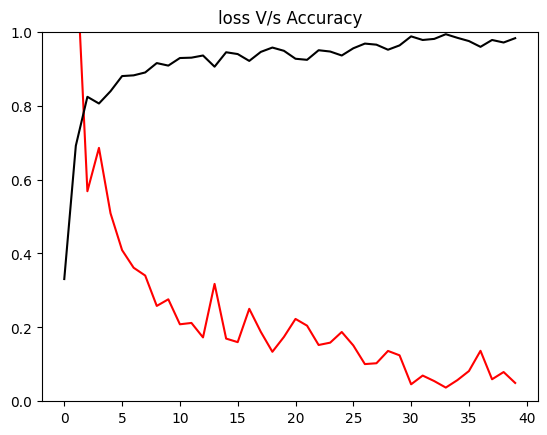

In [57]:
plt.plot(h['loss'], "r")
plt.plot(h['accuracy'], "k")
plt.ylim((0, 1))
plt.title("loss V/s Accuracy")
plt.show()

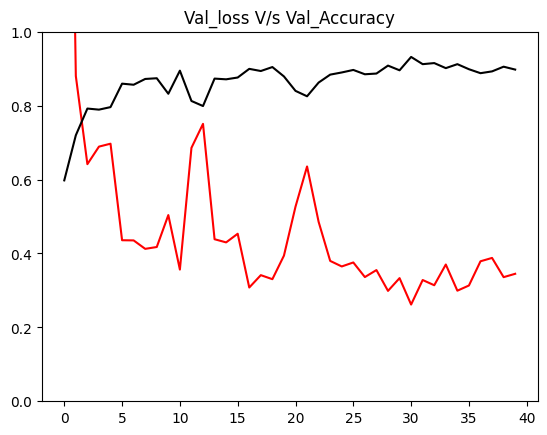

In [58]:
plt.plot(h['val_loss'], "r")
plt.plot(h['val_accuracy'], "k")
plt.ylim((0, 1))
plt.title("Val_loss V/s Val_Accuracy")
plt.show()

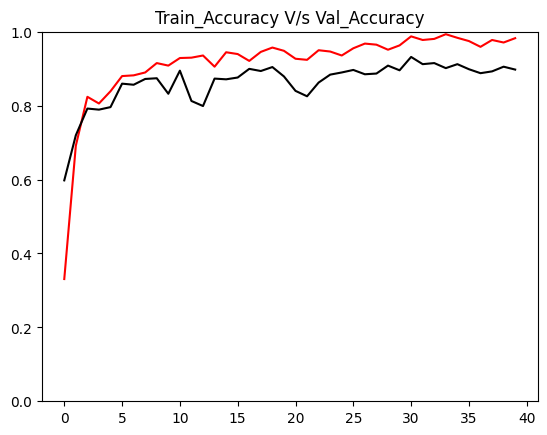

In [59]:
plt.plot(h['accuracy'], "r")
plt.plot(h['val_accuracy'], "k")
plt.ylim((0, 1))
plt.title("Train_Accuracy V/s Val_Accuracy")
plt.show()

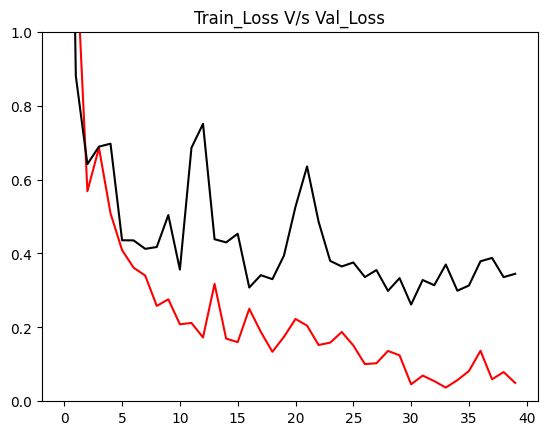

In [60]:
plt.plot(h['loss'], "r")
plt.plot(h['val_loss'], "k")
plt.ylim((0, 1))
plt.title("Train_Loss V/s Val_Loss")
plt.show()